In [1]:
import sys
sys.path.append("/home/ubuntu/workspaces/deepinv/")

In [9]:
from datetime import datetime
import deepinv as dinv
from pathlib import Path
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from deepinv.models import DRUNet
from deepinv.optim.data_fidelity import L2
from deepinv.optim.prior import PnP
from deepinv.optim.optimizers import optim_builder
from deepinv.utils.demo import load_url_image, get_image_url
from deepinv.utils.plotting import plot, plot_curves
from deepinv.optim.phase_retrieval import correct_global_phase, cosine_similarity, spectral_methods
from deepinv.models.complex import to_complex_denoiser

In [3]:
now = datetime.now()
dt_string = now.strftime("%Y%m%d-%H%M%S")

BASE_DIR = Path(".")
DATA_DIR = BASE_DIR / "data"
SAVE_DIR = DATA_DIR / dt_string
FIGURE_DIR = DATA_DIR / "first_results"
Path(SAVE_DIR).mkdir(parents=True, exist_ok=True)
Path(SAVE_DIR / "random").mkdir(parents=True, exist_ok=True)
Path(SAVE_DIR / "pseudorandom").mkdir(parents=True, exist_ok=True)

device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"
device

Selected GPU 0 with 14725 MB free memory 


device(type='cuda', index=0)

In [4]:
# Set up the variable to fetch dataset and operators.
img_size = 99
url = get_image_url("SheppLogan.png")
x = load_url_image(
    url=url, img_size=img_size, grayscale=True, resize_mode="resize", device=device
)
x.shape

torch.Size([1, 1, 99, 99])

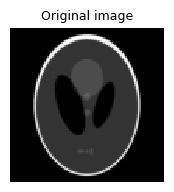

In [5]:
plot(x, titles="Original image")

In [6]:
# generate phase signal

# The phase is computed as 2*pi*x - pi, where x is the original image.
x_phase = torch.exp(1j*x*torch.pi - 0.5j*torch.pi).to(device)

# Every element of the signal should have unit norm.
assert torch.allclose(x_phase.real**2 + x_phase.imag**2, torch.tensor(1.0))

# Generate spectral methods results for pseudorandom phase retrieval

In [12]:
repeat = 10

start = 1
end = 299

res_spec = torch.empty((end-start)//2,repeat)
oversampling_ratios = torch.empty((end-start)//2)

In [13]:
for i in trange(start,end,2):
    for j in range(repeat):
        physics = dinv.physics.PseudoRandomPhaseRetrieval(
            n_layers=2,
            input_shape=(1, img_size, img_size),
            output_shape=(1, i, i),
            dtype=torch.cfloat,
            device=device,
        )
        y = physics(x_phase)

        oversampling_ratios[(i - start)//2] = physics.oversampling_ratio
        x_phase_spec = spectral_methods(y, physics,n_iter=2500)
        res_spec[(i - start)//2,j] = cosine_similarity(x_phase, x_phase_spec)

  0%|          | 0/149 [00:00<?, ?it/s]

100%|██████████| 149/149 [25:50<00:00, 10.41s/it]


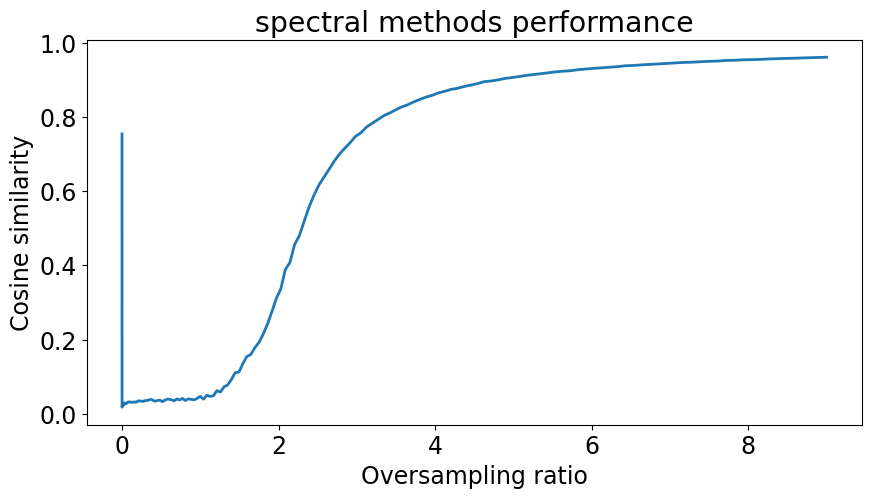

In [14]:
# visualization
plt.figure(figsize=(10, 5))
plt.plot(oversampling_ratios, res_spec.mean(dim=1))
plt.xlabel("Oversampling ratio")
plt.ylabel("Cosine similarity")
plt.title("spectral methods performance")
plt.show()

In [32]:
# save results
torch.save(res_spec, SAVE_DIR / "pseudorandom" / "res_spec.pt")
torch.save(oversampling_ratios, SAVE_DIR / "pseudorandom" / "oversampling_ratios_spec.pt")

# Cosine similarity strangely high at 1

In [30]:
physics = dinv.physics.PseudoRandomPhaseRetrieval(
    n_layers=2,
    input_shape=(1,99,99),
    output_shape=(1,1,1),
    dtype=torch.cfloat,
    device=device,
)

In [28]:
y = physics(x_phase)
torch.allclose(physics.B_adjoint(physics.B(x_phase)), x_phase)

False

In [31]:
cosine_similarity(physics.A_adjoint(y, n_iter=2500),x_phase)

tensor(0.7516, device='cuda:0')

# gradient norm w.r.t. oversampling ratios

In [ ]:
oversampling_ratios = []
mean_gradient = []

data_fidelity = L2()

for i in tqdm(range(1, 299, 2)):
    physics = dinv.physics.PseudoRandomPhaseRetrieval(
    n_layers=2,
    input_shape=(1,99,99),
    output_shape=(1,i,i),
    dtype=torch.cfloat,
    device=device,
) 
    y = physics(x_phase)
    oversampling_ratios.append(physics.oversampling_ratio.item())
    mean_gradient.append(data_fidelity.grad(physics.A_adjoint(y, n_iter=2500), y, physics).mean().norm().item())

In [224]:
plt.plot(oversampling_ratios, mean_gradient)
plt.xlabel('Oversampling ratio')
plt.ylabel('Mean gradient norm')
plt.title('Mean gradient norm vs oversampling ratio')
plt.show()

tensor(10.2499, device='cuda:0')

# gradient descent with spectral methods for pseudorandom phase retrieval

In [67]:
repeat = 5

start = 141
end = 299

res_gd_spec = torch.empty((end-start)//2,repeat)
oversampling_ratios = torch.empty((end-start)//2)

data_fidelity = L2()
prior = dinv.optim.prior.Zero()
max_iter = 10000
early_stop = True
verbose = True

In [68]:
def spectral_methods_wrapper(y, physics, **kwargs):
    x = spectral_methods(y, physics, n_iter=2500, **kwargs)
    z = spectral_methods(y, physics, n_iter=2500, **kwargs)
    return {"est": (x, z)}

In [ ]:
for i in trange(start,end,2):
    params_algo = {"stepsize": 0.006*i**2/(img_size**2), "g_params": 0.00}
    model = optim_builder(
        iteration="PGD",
        prior=prior,
        data_fidelity=data_fidelity,
        early_stop=early_stop,
        max_iter=max_iter,
        verbose=verbose,
        params_algo=params_algo,
        custom_init=spectral_methods_wrapper,
    )
    for j in range(repeat):
        physics = dinv.physics.PseudoRandomPhaseRetrieval(
            n_layers=2,
            input_shape=(1, img_size, img_size),
            output_shape=(1, i, i),
            dtype=torch.cfloat,
            device=device,
        )
        y = physics(x_phase)

        oversampling_ratios[(i - start)//2] = physics.oversampling_ratio

        x_phase_gd_spec, _ = model(y, physics, x_gt=x_phase, compute_metrics=True)

        res_gd_spec[(i - start)//2,j] = cosine_similarity(x_phase, x_phase_gd_spec)

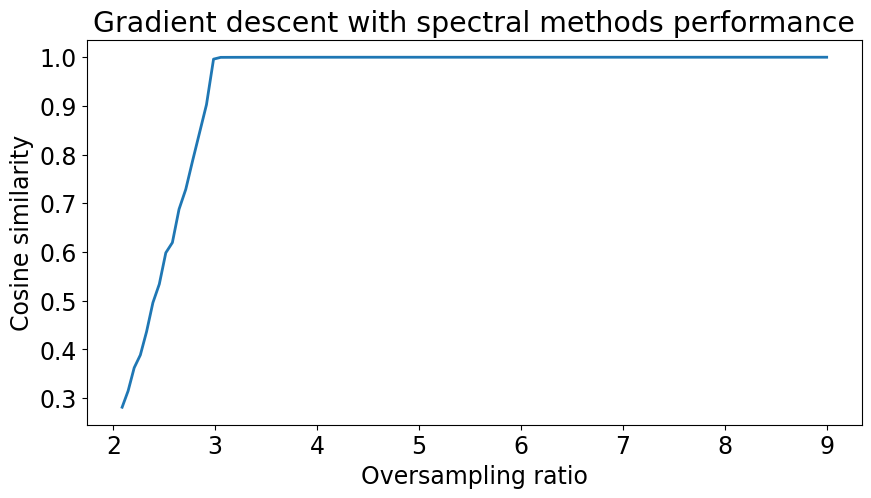

In [ ]:
# visualization
plt.figure(figsize=(10, 5))
plt.plot(oversampling_ratios, res_gd_spec.mean(dim=1))
plt.xlabel("Oversampling ratio")
plt.ylabel("Cosine similarity")
plt.title("Gradient descent with spectral methods performance")
plt.show()

In [ ]:
# save results
torch.save(res_gd_spec, SAVE_DIR / "pseudorandom" / "res_gd_spec_2-9.pt")
torch.save(oversampling_ratios, SAVE_DIR / "pseudorandom" / "oversampling_ratios_gd_spec_2-9.pt")

# Gradient descent with random initialization for pseudorandom phase retrieval

In [73]:
repeat = 10

start = 1
end = 141

res_gd_rand = torch.empty((end-start)//2,repeat)
oversampling_ratios = torch.empty((end-start)//2)

data_fidelity = L2()
prior = dinv.optim.prior.Zero()
max_iter = 10000
early_stop = True
verbose = True

In [74]:
def random_initialization_wrapper(y, physics, **kwargs):
    x_spec = physics.A_adjoint(y, n_iter=100)
    x = torch.randn_like(x_spec)
    z = torch.randn_like(x_spec)
    return {"est": (x, z)}

In [75]:
for i in trange(start,end,2):
    params_algo = {"stepsize": 0.006*i**2/(img_size**2), "g_params": 0.00}
    model = optim_builder(
        iteration="PGD",
        prior=prior,
        data_fidelity=data_fidelity,
        early_stop=early_stop,
        max_iter=max_iter,
        verbose=verbose,
        params_algo=params_algo,
        custom_init=random_initialization_wrapper,
    )
    for j in range(repeat):
        physics = dinv.physics.PseudoRandomPhaseRetrieval(
            n_layers=2,
            input_shape=(1, img_size, img_size),
            output_shape=(1, i, i),
            dtype=torch.cfloat,
            device=device,
        )
        y = physics(x_phase)

        oversampling_ratios[(i - start)//2] = physics.oversampling_ratio

        x_phase_gd_rand, _ = model(y, physics, x_gt=x_phase, compute_metrics=True)

        res_gd_rand[(i - start)//2,j] = cosine_similarity(x_phase, x_phase_gd_rand)

  0%|          | 0/70 [00:00<?, ?it/s]

Iteration 2, current converge crit. = 4.20E-10, objective = 1.00E-05 
Iteration 2, current converge crit. = 5.72E-10, objective = 1.00E-05 
Iteration 2, current converge crit. = 2.61E-09, objective = 1.00E-05 
Iteration 2, current converge crit. = 6.16E-09, objective = 1.00E-05 
Iteration 2, current converge crit. = 1.41E-08, objective = 1.00E-05 


  1%|▏         | 1/70 [00:00<00:33,  2.07it/s]

Iteration 2, current converge crit. = 2.24E-09, objective = 1.00E-05 
Iteration 2, current converge crit. = 3.21E-10, objective = 1.00E-05 
Iteration 2, current converge crit. = 2.11E-08, objective = 1.00E-05 
Iteration 2, current converge crit. = 2.37E-09, objective = 1.00E-05 
Iteration 2, current converge crit. = 5.93E-10, objective = 1.00E-05 
Iteration 2, current converge crit. = 1.02E-06, objective = 1.00E-05 
Iteration 2, current converge crit. = 7.86E-07, objective = 1.00E-05 
Iteration 2, current converge crit. = 7.33E-07, objective = 1.00E-05 
Iteration 2, current converge crit. = 3.75E-07, objective = 1.00E-05 
Iteration 2, current converge crit. = 4.43E-07, objective = 1.00E-05 


  3%|▎         | 2/70 [00:00<00:32,  2.08it/s]

Iteration 2, current converge crit. = 3.84E-07, objective = 1.00E-05 
Iteration 2, current converge crit. = 9.58E-07, objective = 1.00E-05 
Iteration 2, current converge crit. = 2.89E-07, objective = 1.00E-05 
Iteration 2, current converge crit. = 6.20E-07, objective = 1.00E-05 
Iteration 2, current converge crit. = 9.48E-07, objective = 1.00E-05 
Iteration 2, current converge crit. = 1.48E-06, objective = 1.00E-05 
Iteration 2, current converge crit. = 4.35E-06, objective = 1.00E-05 
Iteration 2, current converge crit. = 3.48E-06, objective = 1.00E-05 
Iteration 2, current converge crit. = 1.96E-06, objective = 1.00E-05 
Iteration 2, current converge crit. = 1.70E-06, objective = 1.00E-05 


  4%|▍         | 3/70 [00:01<00:32,  2.08it/s]

Iteration 2, current converge crit. = 3.97E-06, objective = 1.00E-05 
Iteration 2, current converge crit. = 1.93E-06, objective = 1.00E-05 
Iteration 2, current converge crit. = 3.09E-06, objective = 1.00E-05 
Iteration 2, current converge crit. = 4.27E-06, objective = 1.00E-05 
Iteration 2, current converge crit. = 3.11E-06, objective = 1.00E-05 
Iteration 2, current converge crit. = 9.08E-06, objective = 1.00E-05 
Iteration 2, current converge crit. = 9.55E-06, objective = 1.00E-05 
Iteration 2, current converge crit. = 7.91E-06, objective = 1.00E-05 
Iteration 2, current converge crit. = 4.64E-06, objective = 1.00E-05 
Iteration 2, current converge crit. = 4.76E-06, objective = 1.00E-05 


  6%|▌         | 4/70 [00:01<00:31,  2.09it/s]

Iteration 2, current converge crit. = 6.25E-06, objective = 1.00E-05 
Iteration 2, current converge crit. = 8.12E-06, objective = 1.00E-05 
Iteration 2, current converge crit. = 9.98E-06, objective = 1.00E-05 
Iteration 2, current converge crit. = 7.72E-06, objective = 1.00E-05 
Iteration 2, current converge crit. = 8.16E-06, objective = 1.00E-05 
Iteration 635, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 1155, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 693, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2150, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 519, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 810, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 331, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 1232, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 1174, current converge crit. = 1.00E-05, objective = 1.00E-05

  7%|▋         | 5/70 [00:16<06:12,  5.74s/it]

Iteration 934, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2981, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2475, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2368, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2277, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 1989, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2212, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2353, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2488, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2731, current converge crit. = 1.00E-05, objective = 1.00E-05 


  9%|▊         | 6/70 [00:55<17:52, 16.76s/it]

Iteration 2992, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 2953, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2919, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2987, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2313, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2897, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2856, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 3430, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 3170, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2555, current converge crit. = 1.00E-05, objective = 1.00E-05 


 10%|█         | 7/70 [01:39<27:00, 25.73s/it]

Iteration 2768, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 3055, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 3532, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 3139, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 3792, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 3336, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 3201, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 3453, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 3486, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 3167, current converge crit. = 1.00E-05, objective = 1.00E-05 


 11%|█▏        | 8/70 [02:30<34:54, 33.78s/it]

Iteration 3241, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 3106, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 3128, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 3045, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2955, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 3136, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 3099, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 3113, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 3188, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 3343, current converge crit. = 1.00E-05, objective = 1.00E-05 


 13%|█▎        | 9/70 [03:18<38:46, 38.14s/it]

Iteration 3055, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 3539, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 3256, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2918, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2908, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 3237, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 3480, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2824, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2878, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 3063, current converge crit. = 1.00E-05, objective = 1.00E-05 


 14%|█▍        | 10/70 [04:05<40:59, 40.99s/it]

Iteration 3001, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 3123, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2823, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2949, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 3206, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 3047, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 3143, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2951, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 3167, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 3041, current converge crit. = 1.00E-05, objective = 1.00E-05 


 16%|█▌        | 11/70 [04:53<42:17, 43.02s/it]

Iteration 2910, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 3276, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 3018, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2920, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2795, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 2920, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 3291, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 3095, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 2629, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 3228, current converge crit. = 1.00E-05, objective = 1.00E-05 


 17%|█▋        | 12/70 [05:40<43:01, 44.51s/it]

Iteration 3108, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2975, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 3083, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2592, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 3104, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2835, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 3013, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 2716, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 2837, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2870, current converge crit. = 1.00E-05, objective = 1.00E-05 


 19%|█▊        | 13/70 [06:27<42:50, 45.10s/it]

Iteration 2860, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2749, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2676, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 2745, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2795, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 3016, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2644, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 2692, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2722, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2692, current converge crit. = 1.00E-05, objective = 1.00E-05 


 20%|██        | 14/70 [07:10<41:37, 44.60s/it]

Iteration 2860, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2712, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2684, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 2826, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 3063, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 2751, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 2662, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2781, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 2965, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2754, current converge crit. = 1.00E-05, objective = 1.00E-05 


 21%|██▏       | 15/70 [07:53<40:23, 44.06s/it]

Iteration 2684, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 2777, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 3114, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2556, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2569, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 2688, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2584, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2646, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 2709, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2525, current converge crit. = 9.99E-06, objective = 1.00E-05 


 23%|██▎       | 16/70 [08:35<39:07, 43.47s/it]

Iteration 2543, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 2820, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2473, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2405, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 2617, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2443, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2556, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 2559, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 2517, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2605, current converge crit. = 1.00E-05, objective = 1.00E-05 


 24%|██▍       | 17/70 [09:15<37:30, 42.45s/it]

Iteration 2442, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 2613, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 2552, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2504, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2516, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 2814, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2522, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 2511, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 2623, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2472, current converge crit. = 1.00E-05, objective = 1.00E-05 


 26%|██▌       | 18/70 [09:56<36:23, 41.99s/it]

Iteration 2430, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2620, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 2334, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 2334, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 2401, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 2339, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2426, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2582, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2320, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 2446, current converge crit. = 1.00E-05, objective = 1.00E-05 


 27%|██▋       | 19/70 [10:34<34:40, 40.79s/it]

Iteration 2430, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2183, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2492, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 2270, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2347, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2327, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 2353, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 2421, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 2287, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2573, current converge crit. = 1.00E-05, objective = 1.00E-05 


 29%|██▊       | 20/70 [11:13<33:30, 40.21s/it]

Iteration 2329, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 2240, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2301, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 2270, current converge crit. = 1.00E-05, objective = 1.00E-05 


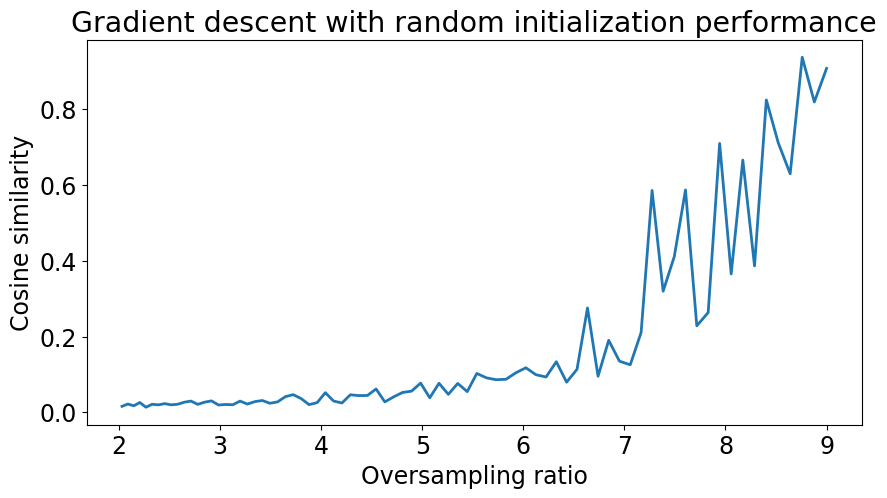

In [ ]:
# visualization
plt.figure(figsize=(10, 5))
plt.plot(oversampling_ratios, res_gd_rand.mean(dim=1))
plt.xlabel("Oversampling ratio")
plt.ylabel("Cosine similarity")
plt.title("Gradient descent with random initialization performance")
plt.show()

In [ ]:
# save results
torch.save(res_gd_spec, SAVE_DIR / "pseudorandom" / "res_gd_rand_0-2.pt")
torch.save(oversampling_ratios, SAVE_DIR / "pseudorandom" / "oversampling_ratios_gd_rand_0-2.pt")